<a href="https://colab.research.google.com/github/jwells52/creating-ai-enabled-systems/blob/main/Research%20Project/notebooks/fsl_experiment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install easyfsl

In [1]:
%pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 1.3 MB/s eta 0:00:00


### Download Humpback Whale Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/Research-Project/kaggle.json /root/.kaggle/kaggle.json && chmod 600 /root/.kaggle/kaggle.json && kaggle competitions download -c humpback-whale-identification

100% 5.50G/5.51G [02:45<00:00, 43.1MB/s]
100% 5.51G/5.51G [02:45<00:00, 35.8MB/s]


In [5]:
%%capture

!unzip humpback-whale-identification.zip

### Clone GitHub Repo

In [6]:
import os

if os.path.exists('/content/creating-ai-enabled-systems/Research Project') == False:
  !git clone https://github.com/jwells52/creating-ai-enabled-systems.git

%cd creating-ai-enabled-systems/Research\ Project

Cloning into 'creating-ai-enabled-systems'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 374 (delta 117), reused 23 (delta 7), pack-reused 187
Receiving objects: 100% (374/374), 159.69 MiB | 19.06 MiB/s, done.
Resolving deltas: 100% (196/196), done.
Updating files: 100% (50/50), done.
/content/creating-ai-enabled-systems/Research Project


### Imports

In [52]:
import os
import cv2
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from easyfsl.methods import PrototypicalNetworks, FewShotClassifier, SimpleShot
from easyfsl.utils import evaluate, evaluate_on_one_task
from easyfsl.samplers import TaskSampler

from torch import Tensor, nn
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet152

from typing import Callable

from modules.data_utils import HumpbackWhaleDataset, remove_new_whale_class, create_loader
from modules.train import train_fsl, device, transform


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
n_way   = 5
n_shot  = 5
n_query = 5

In [54]:
transform

Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(256, 512), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

### Look at classes that have low performance

In [55]:
# Load into dataset
# For each class, calculate accuracy
# Then plot barplot of accuracy for each class
# Look at the characteristics of images for the classes that have low performance

In [56]:
df = remove_new_whale_class(
  pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/images_and_ids.csv')
)

df = df[df.class_count >= 10]

In [57]:
dataset = HumpbackWhaleDataset('/content/train', df, transform=transform)

In [58]:
sampler = TaskSampler(
    dataset, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=500
)

In [59]:
loader = DataLoader(
    dataset,
    batch_sampler=sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=sampler.episodic_collate_fn
)


In [60]:
cnn = resnet18()
cnn.fc = torch.nn.Flatten()
few_shot_classifier = PrototypicalNetworks(cnn).to(device)
few_shot_classifier.load_state_dict(
  torch.load('/content/drive/MyDrive/Research-Project/models/prototypical_network_resnet18_prod_last_epoch')()
)

<All keys matched successfully>

In [62]:
next(iter(loader))[0].shape

torch.Size([25, 3, 256, 512])

In [35]:
%%capture

few_shot_classifier.eval()

In [79]:
df[df['Id'] == 'w_9da1811']

,Image,Id,class_count
889,0ee614bdc.jpg,w_9da1811,21
1768,1de580f9f.jpg,w_9da1811,21
2931,30f028b75.jpg,w_9da1811,21
3825,3ff918da4.jpg,w_9da1811,21
5574,5c75dc38a.jpg,w_9da1811,21
6772,6faef4f7b.jpg,w_9da1811,21
6836,70ced4a03.jpg,w_9da1811,21
7742,7f5cb7222.jpg,w_9da1811,21
7753,7f7a39186.jpg,w_9da1811,21
8976,92865e81d.jpg,w_9da1811,21


In [89]:
from PIL import Image

In [137]:
task_accs = dict()
task_images = dict()

n_tasks = 5
for task in tqdm(range(n_tasks)):
  # Sample n_way random whale_ids
  whale_ids = np.random.choice(df['Id'].unique(), size=n_way, replace=False)

  # Sample n_shot images for each whale_id for support set
  task_support_labels = []
  task_support_image_paths = []
  for i, whale_id in enumerate(whale_ids):
    task_support_image_paths.extend(list(np.random.choice(df[df['Id'] == whale_id]['Image'], size=5, replace=False)))
    task_support_labels.extend([i for _ in range(n_shot)])


  # Sample n_shot images for each whale_id for query set
  task_query_labels = []
  task_query_image_paths = []
  for i, whale_id in enumerate(whale_ids):
    whale_query_images = df[(df['Id'] == whale_id) & ~(df['Image'].isin(task_support_image_paths))]['Image']
    task_query_image_paths.extend(list(np.random.choice(whale_query_images, size=n_query, replace=False)))
    task_query_labels.extend([i for _ in range(n_query)])

  # Load images and labels in tensor
  support_images = np.zeros((n_shot*n_way, 3, 256, 512))
  for i, image_filename in enumerate(task_support_image_paths):
    support_images[i] = transform(Image.open(f'/content/train/{image_filename}')).detach().numpy()

  query_images = np.zeros((n_query*n_way, 3, 256, 512))
  for i, image_filename in enumerate(task_query_image_paths):
    query_images[i] = transform(Image.open(f'/content/train/{image_filename}')).detach().numpy()


  support_labels = torch.Tensor(task_support_labels)
  support_images = torch.Tensor(support_images)
  query_labels = torch.Tensor(task_query_labels)
  query_images = torch.Tensor(query_images)


  few_shot_classifier.process_support_set(support_images.to(device), support_labels.to(device))
  predictions = few_shot_classifier(query_images.to(device)).detach().data
  prediction_labels = torch.max(predictions, 1)[1].cpu().detach().data

  for label in torch.unique(query_labels):

    label_idxs = torch.argwhere(query_labels == label)
    whale_id_acc = (prediction_labels[label_idxs] == query_labels[label_idxs]).sum().item() / n_query
    whale_id = whale_ids[int(label.detach().item())]

    if whale_id not in task_accs:
      task_accs[whale_id] = []

    if whale_id not in task_images:
      task_images[whale_id] = []

    task_accs[whale_id] += [whale_id_acc]
    task_images[whale_id] += [[task_support_image_paths[i] for i in label_idxs]]

100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


In [138]:
task_accs

{'w_db68456': [1.0],
 'w_ac2c28e': [1.0],
 'w_72f3685': [1.0],
 'w_bfcad53': [1.0],
 'w_242fb46': [1.0],
 'w_0b1e4a6': [1.0],
 'w_9f13096': [1.0],
 'w_0f8b8e2': [0.8],
 'w_53feb91': [1.0],
 'w_eba33fb': [1.0],
 'w_accb0cb': [1.0],
 'w_488865e': [1.0],
 'w_b9c99cc': [1.0],
 'w_cbb15d2': [1.0],
 'w_4bf625b': [1.0],
 'w_60ce6fc': [1.0],
 'w_8da30ad': [1.0],
 'w_698fcbe': [1.0, 1.0],
 'w_789c969': [1.0],
 'w_f74a89e': [1.0],
 'w_591a2c5': [1.0],
 'w_26c0ffd': [1.0],
 'w_15805cd': [0.8],
 'w_d8a47de': [1.0]}

In [139]:
task_images

{'w_db68456': [['594eef588.jpg',
   'a511f1690.jpg',
   '8ed127100.jpg',
   '32991140f.jpg',
   'fa6ee3eea.jpg']],
 'w_ac2c28e': [['5b913f7f7.jpg',
   '6ce806022.jpg',
   '6f6be84ca.jpg',
   '0e6abdd05.jpg',
   '5363327d6.jpg']],
 'w_72f3685': [['f631e93d6.jpg',
   'ed306a531.jpg',
   'aea9f24cb.jpg',
   '57fcffc38.jpg',
   '8f3490b0b.jpg']],
 'w_bfcad53': [['8dd500109.jpg',
   'a728123bd.jpg',
   '30b5dc0b9.jpg',
   'cf83d6281.jpg',
   '9ed79e3ae.jpg']],
 'w_242fb46': [['c1d59f8da.jpg',
   '87e5dde9f.jpg',
   '8e4f01cb8.jpg',
   '53f504f45.jpg',
   '91be4e7db.jpg']],
 'w_0b1e4a6': [['80c969923.jpg',
   '0bd1610f8.jpg',
   '7ec61dd72.jpg',
   '4f0be568a.jpg',
   '550b7eb5a.jpg']],
 'w_9f13096': [['f35f3a70c.jpg',
   'ad3bfbd20.jpg',
   'fc12b55f8.jpg',
   '9e37b66de.jpg',
   '04515138c.jpg']],
 'w_0f8b8e2': [['dd7a44da8.jpg',
   '61ad2ad83.jpg',
   '8a2d327e1.jpg',
   'f5c9abd36.jpg',
   'aefc4a406.jpg']],
 'w_53feb91': [['e79e867de.jpg',
   '1d221ce45.jpg',
   'd165ad58c.jpg',
   '9db

In [36]:
class_accs = dict()
for (support_images, support_labels, query_images, query_labels, whale_ids) in tqdm(loader):

    few_shot_classifier.process_support_set(support_images.to(device), support_labels.to(device))
    predictions = few_shot_classifier(query_images.to(device)).detach().data
    prediction_labels = torch.max(predictions, 1)[1].cpu().detach().data

    for label in torch.unique(query_labels):

      label_idxs = torch.argwhere(query_labels == label)
      whale_id_acc = (prediction_labels[label_idxs] == query_labels[label_idxs]).sum().item() / n_query
      whale_id = dataset.id_to_label[whale_ids[label.detach().item()]]

      if whale_id not in class_accs:
        class_accs[whale_id] = [whale_id_acc]
      else:
        class_accs[whale_id] += [whale_id_acc]

  0%|          | 0/500 [00:01<?, ?it/s]


RuntimeError: ignored

In [18]:
class_acc_means = dict()
class_acc_means = {k:np.mean(v) for k, v in class_accs.items()}

In [19]:
len(class_acc_means.keys())


273

In [25]:
percentiles = {
    '<25%': [],
    '25%-50%': [],
    '50%-75%': [],
    '>75%': []
}

In [ ]:
for whale_id, accs in class_accs.items():
  if any([True if acc < 0.5 else False for acc in accs]):
    percentiles['<25%'] += [whale_id]

  if any([True if acc >= 0.5 and acc <= 0.6 else False for acc in accs]):
    percentiles['25%-50%'] += [whale_id]

  if any([True if acc >= 0.7 and acc <= 0.85 else False for acc in accs]):
    percentiles['50%-75%'] += [whale_id]

  if any([True if acc >= 0.7 and acc <= 0.85 else False for acc in accs]):
    percentiles['50%-75%'] += [whale_id]

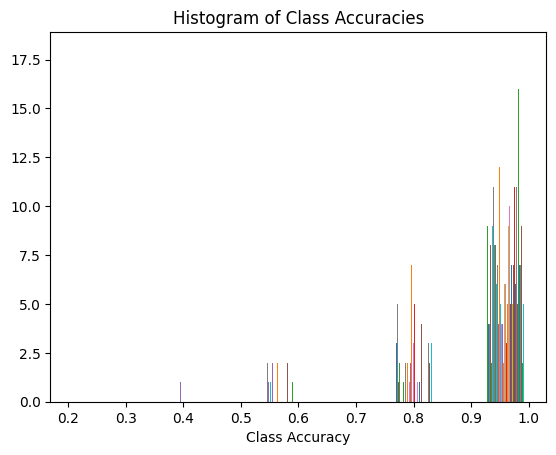

In [131]:
plt.title('Histogram of Class Accuracies')
plt.hist(class_accs.values())
plt.xlabel('Class Accuracy');

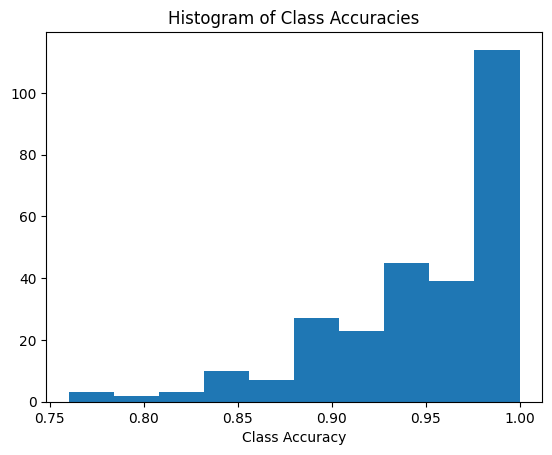

In [21]:
plt.title('Histogram of Class Accuracies')
plt.hist(class_acc_means.values())
plt.xlabel('Class Accuracy');

In [ ]:
# Look at whale_ids that are in the lower spectrum of the histogram

In [22]:
low_performance_classes = []
for k, v in class_acc_means.items():
  if v <= .80:
    low_performance_classes += [k]

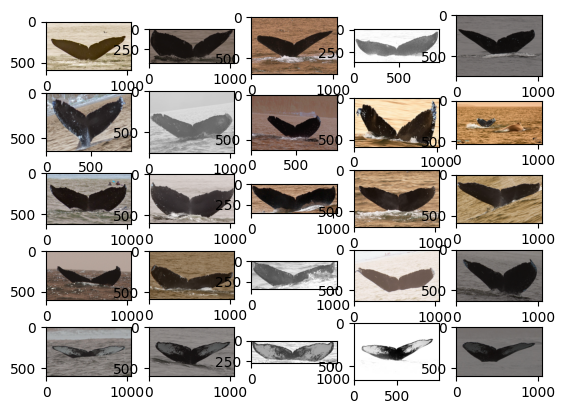

In [23]:
fig, axs = plt.subplots(len(low_performance_classes), 5)
for i, lpc in enumerate(low_performance_classes):
  images = df[df.Id == lpc]['Image']
  for j in range(5):
    axs[i, j].imshow(cv2.imread(f'/content/train/{images.iloc[j]}'))

In [24]:
high_performance_classes = []
for k, v in class_acc_means.items():
  if v > 0.8:
    high_performance_classes += [k]

In [ ]:
low_performance_images = dict()

for lpc in tqdm(low_performance_classes):
  image_filenames = df[df.Id == lpc]['Image']
  low_performance_images[lpc] = []
  for image_filename in image_filenames:
    image = cv2.imread(f'/content/train/{image_filename}')
    low_performance_images[lpc] += [(image.shape[0], image.shape[1])]

100%|██████████| 5/5 [00:00<00:00,  6.01it/s]


In [ ]:
high_performance_images = dict()

for hpc in tqdm(high_performance_classes):
  image_filenames = df[df.Id == hpc]['Image']
  high_performance_images[hpc] = []
  for image_filename in image_filenames:
    image = cv2.imread(f'/content/train/{image_filename}')
    high_performance_images[hpc] += [(image.shape[0], image.shape[1])]

100%|██████████| 268/268 [00:44<00:00,  5.97it/s]


In [ ]:
lpc_mean_heights = []
lpc_mean_widths  = []

for lpc in low_performance_classes:
  lpc_mean_heights += [np.mean([h for h, _ in low_performance_images[lpc]])]
  lpc_mean_widths  += [np.mean([w for _, w in low_performance_images[lpc]])]



In [ ]:
print(np.mean(lpc_mean_heights))
print(np.mean(lpc_mean_widths))

536.815291858679
1005.0294546850998


In [ ]:
hpc_mean_heights = []
hpc_mean_widths  = []

for hpc in high_performance_classes:
  hpc_mean_heights += [np.mean([h for h, _ in high_performance_images[hpc]])]
  hpc_mean_widths  += [np.mean([w for _, w in high_performance_images[hpc]])]

In [ ]:
print(np.mean(hpc_mean_heights))
print(np.mean(hpc_mean_widths))

506.19290079535534
1020.3927176454685
